In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [89]:
import pandas as pd
import seaborn as sns
import time
import math
from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
test_size = 0.2              # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

In [15]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'+str(N)] = mean_list
    df_out[col + '_std'+str(N)] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [215]:
Final = pd.read_csv('data.csv',parse_dates = ['date'])

In [216]:
Final.head()

,Month,Price,Change,Production,year,Weather,oilPrice,date,goldPrice
0,5,261.48,0.00,60117,2009,64.7,57.30,2009-05-01,926.855
1,6,256.64,-1.85,60117,2009,74.8,68.61,2009-06-01,947.807
2,7,224.85,-12.39,60117,2009,73.5,64.44,2009-07-01,934.272
3,8,210.37,-6.44,60117,2009,74.0,72.51,2009-08-01,949.500
4,9,191.09,-9.16,60117,2009,67.0,67.65,2009-09-01,996.443


In [431]:
gold = Final[['date','Month','year','goldPrice']]
# gold = gold.rename(columns={"goldPrice": "Price"})
wheat = Final[['date','Month','year','Price']]
wheat = wheat.rename(columns={"Price": "wheatPrice"})
oil = Final[['date','Month','year','oilPrice']]
# oil = oil.rename(columns={"oilPrice": "Price"})

In [432]:
gold = get_mov_avg_std(gold,'goldPrice', 3)
gold = get_mov_avg_std(gold,'goldPrice', 15)
gold = get_mov_avg_std(gold,'goldPrice', 30)
gold = gold.drop(columns=['goldPrice'])
oil = get_mov_avg_std(oil,'oilPrice', 3)
oil = get_mov_avg_std(oil,'oilPrice', 15)
oil = get_mov_avg_std(oil,'oilPrice', 30)
oil = oil.drop(columns=['oilPrice'])
wheat = get_mov_avg_std(wheat,'wheatPrice', 3)
oil.head()

,date,Month,year,oilPrice_mean3,oilPrice_std3,oilPrice_mean15,oilPrice_std15,oilPrice_mean30,oilPrice_std30
0,2009-05-01,5,2009,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-06-01,6,2009,57.300,NaN,57.300,NaN,57.300,NaN
2,2009-07-01,7,2009,62.955,7.997378,62.955,7.997378,62.955,7.997378
3,2009-08-01,8,2009,63.450,5.719624,63.450,5.719624,63.450,5.719624
4,2009-09-01,9,2009,68.520,4.035753,65.715,6.506174,65.715,6.506174


In [433]:
gold.head()

,date,Month,year,goldPrice_mean3,goldPrice_std3,goldPrice_mean15,goldPrice_std15,goldPrice_mean30,goldPrice_std30
0,2009-05-01,5,2009,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-06-01,6,2009,926.855000,NaN,926.855000,NaN,926.855000,NaN
2,2009-07-01,7,2009,937.331000,14.815301,937.331000,14.815301,937.331000,14.815301
3,2009-08-01,8,2009,936.311333,10.623829,936.311333,10.623829,936.311333,10.623829
4,2009-09-01,9,2009,943.859667,8.346201,939.608500,10.896286,939.608500,10.896286


In [434]:
wheat.head()

,date,Month,year,wheatPrice,wheatPrice_mean3,wheatPrice_std3
0,2009-05-01,5,2009,261.48,NaN,NaN
1,2009-06-01,6,2009,256.64,261.480000,NaN
2,2009-07-01,7,2009,224.85,259.060000,3.422397
3,2009-08-01,8,2009,210.37,247.656667,19.898855
4,2009-09-01,9,2009,191.09,230.620000,23.668500


In [435]:
df = wheat
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]
# merging_keys
merging_keys = ['order_day']
# List of columns that we will use to create lags
lag_cols = ['wheatPrice']

shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
df = df.drop(columns=['order_day'])    
wheat = df
wheat.head()

,date,Month,year,wheatPrice,wheatPrice_mean3,wheatPrice_std3,wheatPrice_lag_1,wheatPrice_lag_2,wheatPrice_lag_3
3,2009-08-01,8,2009,210.37,247.656667,19.898855,224.85,256.64,261.48
4,2009-09-01,9,2009,191.09,230.620000,23.668500,210.37,224.85,256.64
5,2009-10-01,10,2009,198.85,208.770000,16.936777,191.09,210.37,224.85
6,2009-11-01,11,2009,211.04,200.103333,9.700914,198.85,191.09,210.37
7,2009-12-01,12,2009,206.25,200.326667,10.056641,211.04,198.85,191.09


In [436]:
df = pd.merge(wheat,gold, on=['date','Month','year'])
df = pd.merge(df,oil, on=['date','Month','year'])
df.head()

,date,Month,year,wheatPrice,wheatPrice_mean3,wheatPrice_std3,wheatPrice_lag_1,wheatPrice_lag_2,wheatPrice_lag_3,goldPrice_mean3,...,goldPrice_mean15,goldPrice_std15,goldPrice_mean30,goldPrice_std30,oilPrice_mean3,oilPrice_std3,oilPrice_mean15,oilPrice_std15,oilPrice_mean30,oilPrice_std30
0,2009-08-01,8,2009,210.37,247.656667,19.898855,224.85,256.64,261.48,936.311333,...,936.311333,10.623829,936.311333,10.623829,63.450000,5.719624,63.450000,5.719624,63.450000,5.719624
1,2009-09-01,9,2009,191.09,230.620000,23.668500,210.37,224.85,256.64,943.859667,...,939.608500,10.896286,939.608500,10.896286,68.520000,4.035753,65.715000,6.506174,65.715000,6.506174
2,2009-10-01,10,2009,198.85,208.770000,16.936777,191.09,210.37,224.85,960.071667,...,950.975400,27.112338,950.975400,27.112338,68.200000,4.063016,66.102000,5.700576,66.102000,5.700576
3,2009-11-01,11,2009,211.04,200.103333,9.700914,198.85,191.09,210.37,996.484667,...,966.398000,44.891008,966.398000,44.891008,70.976667,2.883909,67.213333,5.779933,67.213333,5.779933
4,2009-12-01,12,2009,206.25,200.326667,10.056641,211.04,198.85,191.09,1055.357667,...,989.215286,72.963931,989.215286,72.963931,72.360000,4.518971,68.562857,6.370886,68.562857,6.370886


In [437]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))
train_cv.head()

train.shape = (71, 21)
cv.shape = (23, 21)
train_cv.shape = (94, 21)
test.shape = (23, 21)


,date,Month,year,wheatPrice,wheatPrice_mean3,wheatPrice_std3,wheatPrice_lag_1,wheatPrice_lag_2,wheatPrice_lag_3,goldPrice_mean3,...,goldPrice_mean15,goldPrice_std15,goldPrice_mean30,goldPrice_std30,oilPrice_mean3,oilPrice_std3,oilPrice_mean15,oilPrice_std15,oilPrice_mean30,oilPrice_std30
0,2009-08-01,8,2009,210.37,247.656667,19.898855,224.85,256.64,261.48,936.311333,...,936.311333,10.623829,936.311333,10.623829,63.450000,5.719624,63.450000,5.719624,63.450000,5.719624
1,2009-09-01,9,2009,191.09,230.620000,23.668500,210.37,224.85,256.64,943.859667,...,939.608500,10.896286,939.608500,10.896286,68.520000,4.035753,65.715000,6.506174,65.715000,6.506174
2,2009-10-01,10,2009,198.85,208.770000,16.936777,191.09,210.37,224.85,960.071667,...,950.975400,27.112338,950.975400,27.112338,68.200000,4.063016,66.102000,5.700576,66.102000,5.700576
3,2009-11-01,11,2009,211.04,200.103333,9.700914,198.85,191.09,210.37,996.484667,...,966.398000,44.891008,966.398000,44.891008,70.976667,2.883909,67.213333,5.779933,67.213333,5.779933
4,2009-12-01,12,2009,206.25,200.326667,10.056641,211.04,198.85,191.09,1055.357667,...,989.215286,72.963931,989.215286,72.963931,72.360000,4.518971,68.562857,6.370886,68.562857,6.370886


In [438]:
train.columns

Index(['date', 'Month', 'year', 'wheatPrice', 'wheatPrice_mean3',
       'wheatPrice_std3', 'wheatPrice_lag_1', 'wheatPrice_lag_2',
       'wheatPrice_lag_3', 'goldPrice_mean3', 'goldPrice_std3',
       'goldPrice_mean15', 'goldPrice_std15', 'goldPrice_mean30',
       'goldPrice_std30', 'oilPrice_mean3', 'oilPrice_std3', 'oilPrice_mean15',
       'oilPrice_std15', 'oilPrice_mean30', 'oilPrice_std30'],
      dtype='object')

In [465]:
cols_to_scale = [
       'Month','year','wheatPrice','wheatPrice_lag_1',
       'wheatPrice_lag_2', 'wheatPrice_lag_3', 'goldPrice_mean3',
       'goldPrice_std3', 'goldPrice_mean15', 'goldPrice_std15',
       'goldPrice_mean30', 'goldPrice_std30', 'oilPrice_mean3',
       'oilPrice_std3', 'oilPrice_mean15', 'oilPrice_std15', 'oilPrice_mean30',
       'oilPrice_std30'
]
    
# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(train_scaled.std(axis=0)))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date']] = train.reset_index()[['date']]

print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [   6.49295775 2012.04225352  278.66126761  278.87309859  279.45507042
  279.99140845 1375.67365258   38.54647711 1354.46487188   97.58610022
 1331.72404851  157.02880537   96.29830986    4.15607069   95.82937417
    8.54399075   92.87302927   10.90640733]
scaler.var_ = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
train_scaled.shape = (71, 18)
train_scaled.shape = (71, 19)


,Month,year,wheatPrice,wheatPrice_lag_1,wheatPrice_lag_2,wheatPrice_lag_3,goldPrice_mean3,goldPrice_std3,goldPrice_mean15,goldPrice_std15,goldPrice_mean30,goldPrice_std30,oilPrice_mean3,oilPrice_std3,oilPrice_mean15,oilPrice_std15,oilPrice_mean30,oilPrice_std30,date
0,0.433586,-1.732719,-1.318039,-1.047751,-0.446730,-0.365274,-1.970324,-1.214125,-1.836405,-1.945816,-1.878600,-2.682183,-1.739616,0.501053,-1.958450,-0.526237,-1.859649,-0.971475,2009-08-01
1,0.721292,-1.732719,-1.690148,-1.328584,-1.069194,-0.460778,-1.936474,-1.313160,-1.821925,-1.939720,-1.862935,-2.677192,-1.471114,-0.038557,-1.821452,-0.379687,-1.716493,-0.824155,2009-09-01
2,1.008999,-1.732719,-1.540378,-1.702510,-1.352720,-1.088070,-1.863771,-0.267012,-1.772005,-1.576879,-1.808931,-2.380109,-1.488060,-0.029820,-1.798045,-0.529786,-1.692033,-0.975042,2009-10-01
3,1.296705,-1.732719,-1.305108,-1.552009,-1.730231,-1.373794,-1.700476,0.367814,-1.704274,-1.179074,-1.735659,-2.054398,-1.341011,-0.407674,-1.730826,-0.515000,-1.621792,-0.960179,2009-11-01
4,1.584412,-1.732719,-1.397556,-1.315590,-1.578287,-1.754234,-1.436460,1.178277,-1.604067,-0.550931,-1.627254,-1.540094,-1.267751,0.116294,-1.649201,-0.404894,-1.536497,-0.849494,2009-12-01


In [440]:
train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 19 columns):
Month               71 non-null float64
year                71 non-null float64
wheatPrice          71 non-null float64
wheatPrice_lag_1    71 non-null float64
wheatPrice_lag_2    71 non-null float64
wheatPrice_lag_3    71 non-null float64
goldPrice_mean3     71 non-null float64
goldPrice_std3      71 non-null float64
goldPrice_mean15    71 non-null float64
goldPrice_std15     71 non-null float64
goldPrice_mean30    71 non-null float64
goldPrice_std30     71 non-null float64
oilPrice_mean3      71 non-null float64
oilPrice_std3       71 non-null float64
oilPrice_mean15     71 non-null float64
oilPrice_std15      71 non-null float64
oilPrice_mean30     71 non-null float64
oilPrice_std30      71 non-null float64
date                71 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(18)
memory usage: 10.6 KB


In [441]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(train_scaled.std(axis=0)))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date']] = train_cv.reset_index()[[ 'date']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [   6.5        2013.          251.94        252.41276596  253.37617021
  254.51617021 1333.91341489   37.15283202 1316.44827557   90.09327077
 1306.85840579  138.1304358    84.3243617     3.96256624   85.39951312
    9.32842336   87.59569941   14.01268939]
scaler_train_cv.var_ = Month               1.007118
year                1.007118
wheatPrice          1.007118
wheatPrice_lag_1    1.007118
wheatPrice_lag_2    1.007118
wheatPrice_lag_3    1.007118
goldPrice_mean3     1.007118
goldPrice_std3      1.007118
goldPrice_mean15    1.007118
goldPrice_std15     1.007118
goldPrice_mean30    1.007118
goldPrice_std30     1.007118
oilPrice_mean3      1.007118
oilPrice_std3       1.007118
oilPrice_mean15     1.007118
oilPrice_std15      1.007118
oilPrice_mean30     1.007118
oilPrice_std30      1.007118
dtype: float64
train_cv_scaled.shape = (94, 18)
train_cv_scaled.shape = (94, 19)


,Month,year,wheatPrice,wheatPrice_lag_1,wheatPrice_lag_2,wheatPrice_lag_3,goldPrice_mean3,goldPrice_std3,goldPrice_mean15,goldPrice_std15,goldPrice_mean30,goldPrice_std30,oilPrice_mean3,oilPrice_std3,oilPrice_mean15,oilPrice_std15,oilPrice_mean30,oilPrice_std30,date
0,0.430068,-1.741338,-0.633960,-0.422652,0.050526,0.109186,-1.891464,-1.198499,-1.815892,-1.899634,-1.964609,-2.185341,-0.775425,0.608522,-0.915347,-0.642905,-1.344144,-1.083075,2009-08-01
1,0.716780,-1.741338,-0.927987,-0.644691,-0.441600,0.033300,-1.855556,-1.301396,-1.800142,-1.893121,-1.947128,-2.180671,-0.587088,0.025347,-0.820891,-0.502782,-1.218056,-0.980351,2009-09-01
2,1.003492,-1.741338,-0.809644,-0.940334,-0.665758,-0.465136,-1.778432,-0.214462,-1.745843,-1.505494,-1.886862,-1.902744,-0.598975,0.034789,-0.804752,-0.646299,-1.196512,-1.085563,2009-10-01
3,1.290204,-1.741338,-0.623742,-0.821341,-0.964222,-0.692168,-1.605209,0.445114,-1.672170,-1.080513,-1.805092,-1.598034,-0.495830,-0.373571,-0.758407,-0.632161,-1.134646,-1.075199,2009-11-01
4,1.576916,-1.741338,-0.696791,-0.634417,-0.844094,-0.994460,-1.325140,1.287175,-1.563173,-0.409459,-1.684117,-1.116891,-0.444443,0.192700,-0.702129,-0.526883,-1.059521,-0.998020,2009-12-01


In [539]:
train_cv_scaled['goldPrice_std3'][-1:]

93   -0.766029
Name: goldPrice_std3, dtype: float64

In [442]:
cv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 71 to 93
Data columns (total 21 columns):
date                23 non-null datetime64[ns]
Month               23 non-null int64
year                23 non-null int64
wheatPrice          23 non-null float64
wheatPrice_mean3    23 non-null float64
wheatPrice_std3     23 non-null float64
wheatPrice_lag_1    23 non-null float64
wheatPrice_lag_2    23 non-null float64
wheatPrice_lag_3    23 non-null float64
goldPrice_mean3     23 non-null float64
goldPrice_std3      23 non-null float64
goldPrice_mean15    23 non-null float64
goldPrice_std15     23 non-null float64
goldPrice_mean30    23 non-null float64
goldPrice_std30     23 non-null float64
oilPrice_mean3      23 non-null float64
oilPrice_std3       23 non-null float64
oilPrice_mean15     23 non-null float64
oilPrice_std15      23 non-null float64
oilPrice_mean30     23 non-null float64
oilPrice_std30      23 non-null float64
dtypes: datetime64[ns](1), float64(18), int64(2)
memo

In [443]:
cv['wheatPrice_std3']

71     6.835381
72     9.228310
73    15.137612
74    12.683253
75     4.027021
76     2.537459
77     8.556863
78     8.415535
79     3.164891
80     3.164891
81     2.235829
82    10.139193
83     8.608560
84    11.998404
85    13.108365
86     1.289431
87     1.289431
88     0.635085
89     5.437659
90     5.973963
91     7.166480
92     0.925851
93     6.586420
Name: wheatPrice_std3, dtype: float64

In [444]:
cols_to_scale = [
       'Month','year' ,'goldPrice_mean3',
       'goldPrice_std3', 'goldPrice_mean15', 'goldPrice_std15',
       'goldPrice_mean30', 'goldPrice_std30', 'oilPrice_mean3',
       'oilPrice_std3', 'oilPrice_mean15', 'oilPrice_std15', 'oilPrice_mean30',
       'oilPrice_std30'
]
# # Do scaling for dev set
scaler_cv = StandardScaler()
cv_scaled = scaler_cv.fit_transform(cv[cols_to_scale])

# Convert the numpy array back into pandas datafram
cv_scaled = pd.DataFrame(cv_scaled, columns=cols_to_scale)
cv_scaled[['date','wheatPrice']] = cv.reset_index()[['date','wheatPrice']]

print("cv_scaled.shape = " + str(cv_scaled.shape))
# Now the entire dev set is scaled
cols_list = [
    'wheatPrice'
]
# Do scaling for dev set
temp2 = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean3'], row[col+'_std3']), axis=1)
    temp2 = pd.concat([temp2, temp], axis=1)
    
# Now the entire dev set is scaled
print(cv_scaled.shape)
cv_scaled = pd.merge(cv_scaled,temp2, on=['date'])
cv_scaled.head()

cv_scaled.shape = (23, 16)



(23, 16)


,Month,year,goldPrice_mean3,goldPrice_std3,goldPrice_mean15,goldPrice_std15,goldPrice_mean30,goldPrice_std30,oilPrice_mean3,oilPrice_std3,oilPrice_mean15,oilPrice_std15,oilPrice_mean30,oilPrice_std30,date,wheatPrice,wheatPrice_lag_1,wheatPrice_lag_2,wheatPrice_lag_3
0,0.135689,-1.38587,-0.171957,-1.279311,1.332693,-1.138033,2.851853,3.421814,1.983135,-0.572711,2.377530,2.040494,1.671282,-0.352364,2015-07-01,197.31,-0.931428,-0.125328,1.056757
1,0.419402,-1.38587,-0.483342,0.093148,0.941224,-0.905682,2.225967,2.381364,1.846609,0.241228,2.082475,1.952038,1.536550,-0.208481,2015-08-01,179.68,-1.102044,0.252484,0.849560
2,0.703115,-1.38587,-0.857711,0.064209,0.540896,-0.673477,1.631523,1.370889,1.036678,2.263419,1.719303,1.851963,1.370453,-0.012034,2015-09-01,172.70,-1.051685,0.112964,0.938721
3,0.986827,-1.38587,-1.125522,-1.389656,0.183630,-0.580186,1.091587,0.300416,0.397405,1.137907,1.349447,1.519242,1.225091,0.169540,2015-10-01,172.71,-0.830229,-0.279897,1.110125
4,1.270540,-1.38587,-1.006228,-0.634724,-0.180442,-1.027713,0.710729,-0.344333,0.022420,-1.278833,1.013245,1.107918,1.096523,0.334829,2015-11-01,177.10,-0.576108,-0.578591,1.154700


In [445]:
# Do scaling for test set
scaler_test= StandardScaler()
test_scaled = scaler_test.fit_transform(test[cols_to_scale])

# Convert the numpy array back into pandas dataframe
test_scaled = pd.DataFrame(test_scaled, columns=cols_to_scale)
test_scaled[['date','wheatPrice']] = test.reset_index()[['date','wheatPrice']]

temp2 = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean3'], row[col+'_std3']), axis=1)
    temp2 = pd.concat([temp2, temp], axis=1)
    

print("test_scaled.shape = " + str(test_scaled.shape))
test_scaled = pd.merge(test_scaled,temp2, on=['date'])
# Now the entire dev set is scaled
test_scaled.head()


test_scaled.shape = (23, 16)


,Month,year,goldPrice_mean3,goldPrice_std3,goldPrice_mean15,goldPrice_std15,goldPrice_mean30,goldPrice_std30,oilPrice_mean3,oilPrice_std3,oilPrice_mean15,oilPrice_std15,oilPrice_mean30,oilPrice_std30,date,wheatPrice,wheatPrice_lag_1,wheatPrice_lag_2,wheatPrice_lag_3
0,-0.160948,-1.280369,-0.671564,-0.320851,-1.046802,0.850882,-1.527872,0.646413,-1.332674,-1.107918,-1.382537,-0.907461,-0.816991,-0.894513,2017-06-01,189.60,1.031169,-0.065564,-0.965605
1,0.123806,-1.280369,-0.398152,-0.918364,-0.965034,0.836979,-1.440862,0.696182,-1.520411,-0.261722,-1.311991,-1.290374,-0.928650,-1.127808,2017-07-01,202.46,0.919861,0.144546,-1.064407
2,0.408561,-1.280369,-0.688178,-0.755782,-0.999741,0.867201,-1.461218,0.678629,-1.658157,-0.698179,-1.252339,-1.535120,-0.923616,-1.128981,2017-08-01,171.23,1.050640,-0.110451,-0.940189
3,0.693316,-1.280369,-0.358154,0.132061,-0.879725,0.932334,-1.388821,0.767647,-1.608885,-0.404117,-1.209458,-1.543475,-0.968364,-1.241846,2017-09-01,178.57,-1.053360,0.936344,0.117016
4,0.978070,-1.280369,0.146501,1.680078,-0.642234,1.287293,-1.193726,0.946307,-1.257147,0.084280,-1.141160,-1.371236,-0.966546,-1.236309,2017-10-01,175.63,-0.337834,-0.787326,1.125160


In [446]:
test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 0 to 22
Data columns (total 19 columns):
Month               23 non-null float64
year                23 non-null float64
goldPrice_mean3     23 non-null float64
goldPrice_std3      23 non-null float64
goldPrice_mean15    23 non-null float64
goldPrice_std15     23 non-null float64
goldPrice_mean30    23 non-null float64
goldPrice_std30     23 non-null float64
oilPrice_mean3      23 non-null float64
oilPrice_std3       23 non-null float64
oilPrice_mean15     23 non-null float64
oilPrice_std15      23 non-null float64
oilPrice_mean30     23 non-null float64
oilPrice_std30      23 non-null float64
date                23 non-null datetime64[ns]
wheatPrice          23 non-null float64
wheatPrice_lag_1    23 non-null float64
wheatPrice_lag_2    23 non-null float64
wheatPrice_lag_3    23 non-null float64
dtypes: datetime64[ns](1), float64(18)
memory usage: 3.6 KB


In [546]:
train_cv_scaled.columns

Index(['Month', 'year', 'wheatPrice', 'wheatPrice_lag_1', 'wheatPrice_lag_2',
       'wheatPrice_lag_3', 'goldPrice_mean3', 'goldPrice_std3',
       'goldPrice_mean15', 'goldPrice_std15', 'goldPrice_mean30',
       'goldPrice_std30', 'oilPrice_mean3', 'oilPrice_std3', 'oilPrice_mean15',
       'oilPrice_std15', 'oilPrice_mean30', 'oilPrice_std30', 'date'],
      dtype='object')

In [560]:
temp = train_cv_scaled[[ 'goldPrice_mean3', 'goldPrice_std3',
       'goldPrice_mean15', 'goldPrice_std15', 'goldPrice_mean30',
       'goldPrice_std30', 'oilPrice_mean3', 'oilPrice_std3', 'oilPrice_mean15',
       'oilPrice_std15', 'oilPrice_mean30', 'oilPrice_std30']].tail(1)
temp2 = temp
for i in range(14):
    temp2 = pd.concat([temp2,temp])
temp2 = temp2.reset_index()

In [561]:
test_new

,wheatPrice_lag_1,wheatPrice_lag_2,wheatPrice_lag_3
0,1.031169e+00,-6.556417e-02,-9.656046e-01
1,9.198612e-01,1.445456e-01,-1.064407e+00
2,1.050640e+00,-1.104512e-01,-9.401891e-01
3,-1.053360e+00,9.363437e-01,1.170164e-01
4,-3.378338e-01,-7.873264e-01,1.125160e+00
5,1.317408e-01,9.275999e-01,-1.059341e+00
6,8.218759e-01,-1.113355e+00,2.914793e-01
7,1.013878e+00,-2.836024e-02,-9.855182e-01
8,1.082479e+00,-1.931306e-01,-8.893482e-01
9,5.773503e-01,5.773503e-01,-1.154701e+00


In [447]:
test_scaled.columns

Index(['Month', 'year', 'goldPrice_mean3', 'goldPrice_std3',
       'goldPrice_mean15', 'goldPrice_std15', 'goldPrice_mean30',
       'goldPrice_std30', 'oilPrice_mean3', 'oilPrice_std3', 'oilPrice_mean15',
       'oilPrice_std15', 'oilPrice_mean30', 'oilPrice_std30', 'date',
       'wheatPrice', 'wheatPrice_lag_1', 'wheatPrice_lag_2',
       'wheatPrice_lag_3'],
      dtype='object')

In [448]:
features = ['wheatPrice_lag_1', 'wheatPrice_lag_2',
       'wheatPrice_lag_3', 'goldPrice_mean3', 'goldPrice_std3',
       'goldPrice_mean15', 'goldPrice_std15', 'goldPrice_mean30',
       'goldPrice_std30', 'oilPrice_mean3', 'oilPrice_std3', 'oilPrice_mean15',
       'oilPrice_std15', 'oilPrice_mean30', 'oilPrice_std30']


target = 'wheatPrice'


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (71, 15)
y_train.shape = (71,)
X_cv.shape = (23, 15)
y_cv.shape = (23,)
X_train_cv.shape = (94, 15)
y_train_cv.shape = (94,)
X_sample.shape = (23, 15)
y_sample.shape = (23,)


In [449]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (71, 15)
y_train_scaled.shape = (71,)
X_cv_scaled.shape = (23, 15)
X_train_cv_scaled.shape = (94, 15)
y_train_cv_scaled.shape = (94,)
X_sample_scaled.shape = (23, 15)


In [574]:
X_test_new

,wheatPrice_lag_1,wheatPrice_lag_2,wheatPrice_lag_3,goldPrice_mean3,goldPrice_std3,goldPrice_mean15,goldPrice_std15,goldPrice_mean30,goldPrice_std30,oilPrice_mean3,oilPrice_std3,oilPrice_mean15,oilPrice_std15,oilPrice_mean30,oilPrice_std30
0,1.031169e+00,-6.556417e-02,-9.656046e-01,-0.428364,-0.766029,-0.299414,-0.882696,-0.530123,-1.15206,-1.166461,-0.775327,-1.600712,-0.541585,-2.081838,-0.536868
1,9.198612e-01,1.445456e-01,-1.064407e+00,-0.428364,-0.766029,-0.299414,-0.882696,-0.530123,-1.15206,-1.166461,-0.775327,-1.600712,-0.541585,-2.081838,-0.536868
2,1.050640e+00,-1.104512e-01,-9.401891e-01,-0.428364,-0.766029,-0.299414,-0.882696,-0.530123,-1.15206,-1.166461,-0.775327,-1.600712,-0.541585,-2.081838,-0.536868
3,-1.053360e+00,9.363437e-01,1.170164e-01,-0.428364,-0.766029,-0.299414,-0.882696,-0.530123,-1.15206,-1.166461,-0.775327,-1.600712,-0.541585,-2.081838,-0.536868
4,-3.378338e-01,-7.873264e-01,1.125160e+00,-0.428364,-0.766029,-0.299414,-0.882696,-0.530123,-1.15206,-1.166461,-0.775327,-1.600712,-0.541585,-2.081838,-0.536868
5,1.317408e-01,9.275999e-01,-1.059341e+00,-0.428364,-0.766029,-0.299414,-0.882696,-0.530123,-1.15206,-1.166461,-0.775327,-1.600712,-0.541585,-2.081838,-0.536868
6,8.218759e-01,-1.113355e+00,2.914793e-01,-0.428364,-0.766029,-0.299414,-0.882696,-0.530123,-1.15206,-1.166461,-0.775327,-1.600712,-0.541585,-2.081838,-0.536868
7,1.013878e+00,-2.836024e-02,-9.855182e-01,-0.428364,-0.766029,-0.299414,-0.882696,-0.530123,-1.15206,-1.166461,-0.775327,-1.600712,-0.541585,-2.081838,-0.536868
8,1.082479e+00,-1.931306e-01,-8.893482e-01,-0.428364,-0.766029,-0.299414,-0.882696,-0.530123,-1.15206,-1.166461,-0.775327,-1.600712,-0.541585,-2.081838,-0.536868
9,5.773503e-01,5.773503e-01,-1.154701e+00,-0.428364,-0.766029,-0.299414,-0.882696,-0.530123,-1.15206,-1.166461,-0.775327,-1.600712,-0.541585,-2.081838,-0.536868


In [566]:
test_new = test_scaled.head(15)[['wheatPrice_lag_1','wheatPrice_lag_2','wheatPrice_lag_3']]
test_new = pd.concat([test_new,temp2],axis = 1)
X_test_new = test_new.drop('index',axis = 1)
y_test_new = y_sample.head(15)
y_test_new

94     189.60
95     202.46
96     171.23
97     178.57
98     175.63
99     179.68
100    184.09
101    192.17
102    192.17
103    192.17
104    213.85
105    213.85
106    219.36
107    218.26
108    236.63
Name: wheatPrice, dtype: float64

In [450]:
X_cv_scaled.head()

,wheatPrice_lag_1,wheatPrice_lag_2,wheatPrice_lag_3,goldPrice_mean3,goldPrice_std3,goldPrice_mean15,goldPrice_std15,goldPrice_mean30,goldPrice_std30,oilPrice_mean3,oilPrice_std3,oilPrice_mean15,oilPrice_std15,oilPrice_mean30,oilPrice_std30
0,-0.931428,-0.125328,1.056757,-0.171957,-1.279311,1.332693,-1.138033,2.851853,3.421814,1.983135,-0.572711,2.377530,2.040494,1.671282,-0.352364
1,-1.102044,0.252484,0.849560,-0.483342,0.093148,0.941224,-0.905682,2.225967,2.381364,1.846609,0.241228,2.082475,1.952038,1.536550,-0.208481
2,-1.051685,0.112964,0.938721,-0.857711,0.064209,0.540896,-0.673477,1.631523,1.370889,1.036678,2.263419,1.719303,1.851963,1.370453,-0.012034
3,-0.830229,-0.279897,1.110125,-1.125522,-1.389656,0.183630,-0.580186,1.091587,0.300416,0.397405,1.137907,1.349447,1.519242,1.225091,0.169540
4,-0.576108,-0.578591,1.154700,-1.006228,-0.634724,-0.180442,-1.027713,0.710729,-0.344333,0.022420,-1.278833,1.013245,1.107918,1.096523,0.334829


In [451]:
X_train_scaled.head()

,wheatPrice_lag_1,wheatPrice_lag_2,wheatPrice_lag_3,goldPrice_mean3,goldPrice_std3,goldPrice_mean15,goldPrice_std15,goldPrice_mean30,goldPrice_std30,oilPrice_mean3,oilPrice_std3,oilPrice_mean15,oilPrice_std15,oilPrice_mean30,oilPrice_std30
0,-1.047751,-0.446730,-0.365274,-1.970324,-1.214125,-1.836405,-1.945816,-1.878600,-2.682183,-1.739616,0.501053,-1.958450,-0.526237,-1.859649,-0.971475
1,-1.328584,-1.069194,-0.460778,-1.936474,-1.313160,-1.821925,-1.939720,-1.862935,-2.677192,-1.471114,-0.038557,-1.821452,-0.379687,-1.716493,-0.824155
2,-1.702510,-1.352720,-1.088070,-1.863771,-0.267012,-1.772005,-1.576879,-1.808931,-2.380109,-1.488060,-0.029820,-1.798045,-0.529786,-1.692033,-0.975042
3,-1.552009,-1.730231,-1.373794,-1.700476,0.367814,-1.704274,-1.179074,-1.735659,-2.054398,-1.341011,-0.407674,-1.730826,-0.515000,-1.621792,-0.960179
4,-1.315590,-1.578287,-1.754234,-1.436460,1.178277,-1.604067,-0.550931,-1.627254,-1.540094,-1.267751,0.116294,-1.649201,-0.404894,-1.536497,-0.849494


Text(0.5, 1.0, 'Without scaling')

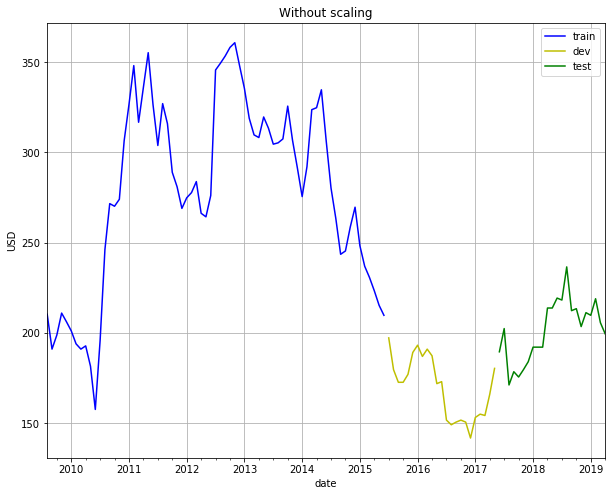

In [452]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='wheatPrice', style='b-', grid=True)
ax = cv.plot(x='date', y='wheatPrice', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='wheatPrice', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'Without scaling')

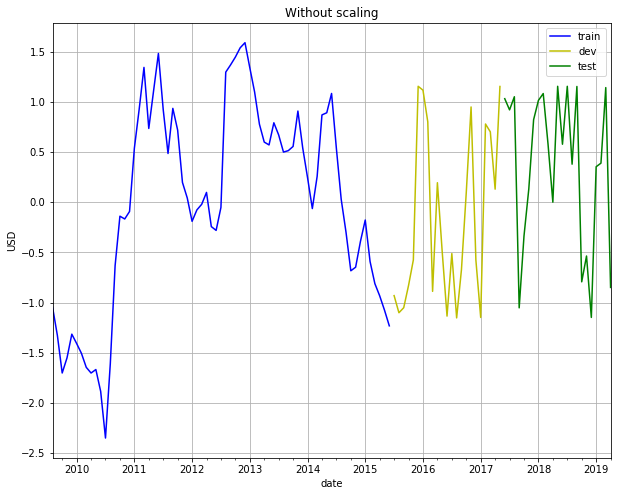

In [453]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='wheatPrice_lag_1', style='b-', grid=True)
ax = cv_scaled.plot(x='date', y='wheatPrice_lag_1', style='y-', grid=True, ax=ax)
ax = test_scaled.plot(x='date', y='wheatPrice_lag_1', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

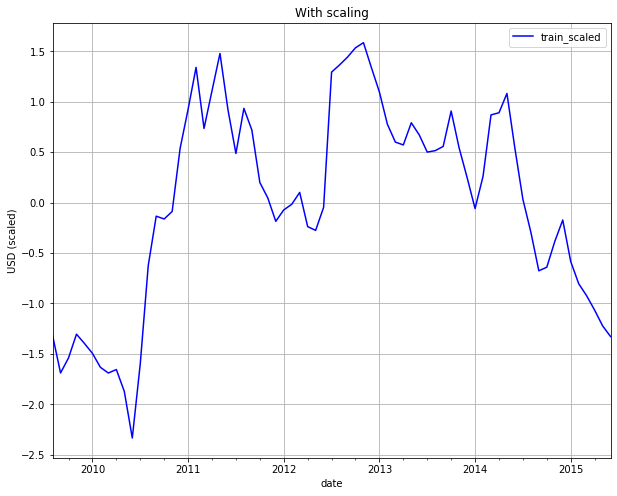

In [454]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='wheatPrice', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

In [455]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

[15:59:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

In [462]:
train.columns

Index(['date', 'Month', 'year', 'wheatPrice', 'wheatPrice_mean3',
       'wheatPrice_std3', 'wheatPrice_lag_1', 'wheatPrice_lag_2',
       'wheatPrice_lag_3', 'goldPrice_mean3', 'goldPrice_std3',
       'goldPrice_mean15', 'goldPrice_std15', 'goldPrice_mean30',
       'goldPrice_std30', 'oilPrice_mean3', 'oilPrice_std3', 'oilPrice_mean15',
       'oilPrice_std15', 'oilPrice_mean30', 'oilPrice_std30'],
      dtype='object')

In [467]:
scaler.mean_

array([   6.49295775, 2012.04225352,  278.66126761,  278.87309859,
        279.45507042,  279.99140845, 1375.67365258,   38.54647711,
       1354.46487188,   97.58610022, 1331.72404851,  157.02880537,
         96.29830986,    4.15607069,   95.82937417,    8.54399075,
         92.87302927,   10.90640733])

In [468]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[2]) + scaler.mean_[2]
# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))
# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 2.366
MAPE on train set = 0.689%


Text(0.5, 1.0, 'Without scaling')

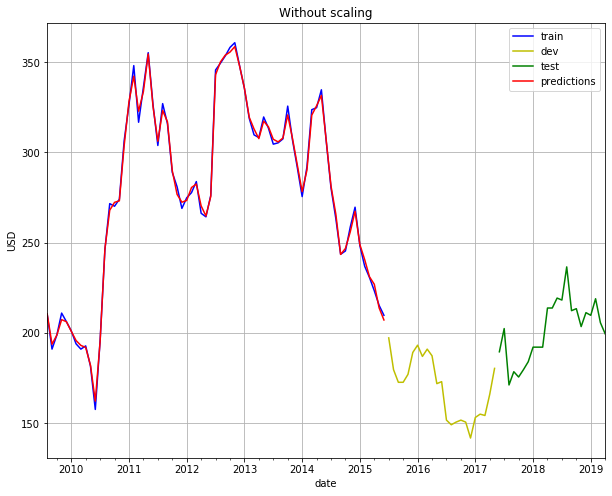

In [469]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='wheatPrice', style='b-', grid=True)
ax = cv.plot(x='date', y='wheatPrice', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='wheatPrice', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [470]:
est_scaled

array([-1.3149486 , -1.6378558 , -1.5412436 , -1.3751878 , -1.3977473 ,
       -1.4993356 , -1.5986171 , -1.6504462 , -1.6726515 , -1.8632424 ,
       -2.2462273 , -1.6080215 , -0.6184417 , -0.20545721, -0.12105352,
       -0.10503584,  0.48628324,  0.9560629 ,  1.227878  ,  0.8532599 ,
        1.063547  ,  1.4650105 ,  0.90282094,  0.5318364 ,  0.86111516,
        0.7395233 ,  0.21848631, -0.03611934, -0.11980426, -0.10094285,
        0.03737777,  0.07447907, -0.15885162, -0.26664132, -0.05808014,
        1.2429035 ,  1.3781719 ,  1.4512118 ,  1.4853196 ,  1.5437536 ,
        1.3350432 ,  1.0992737 ,  0.7887129 ,  0.66268414,  0.5602346 ,
        0.7471169 ,  0.685351  ,  0.5531324 ,  0.5249241 ,  0.5661829 ,
        0.8133905 ,  0.55984867,  0.27672988, -0.00660318,  0.22436142,
        0.81104165,  0.9110358 ,  1.0210801 ,  0.5436304 ,  0.05312467,
       -0.24645597, -0.6777923 , -0.61397016, -0.43704116, -0.21597672,
       -0.5730144 , -0.7333555 , -0.91737187, -0.9971949 , -1.24

RMSE on dev set = 10.104
MAPE on dev set = 4.732%


Text(0, 0.5, 'USD')

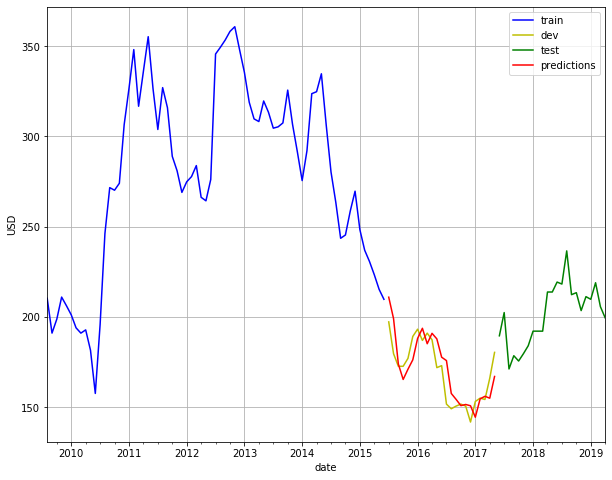

In [471]:

# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['wheatPrice_std3'] + cv['wheatPrice_mean3']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='wheatPrice', style='b-', grid=True)
ax = cv.plot(x='date', y='wheatPrice', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='wheatPrice', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

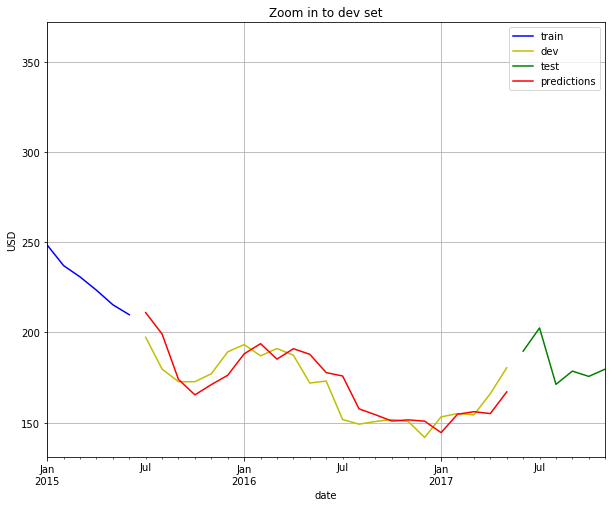

In [473]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='wheatPrice', style='b-', grid=True)
ax = cv.plot(x='date', y='wheatPrice', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='wheatPrice', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2015, 1, 1), date(2017, 11, 1)])
ax.set_title("Zoom in to dev set")

# Features importance

In [474]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('oilPrice_std30', 0.02048394),
 ('wheatPrice_lag_3', 0.020866696),
 ('oilPrice_mean3', 0.030417709),
 ('goldPrice_std15', 0.037767265),
 ('goldPrice_mean30', 0.038207773),
 ('oilPrice_mean30', 0.04008748),
 ('goldPrice_std30', 0.056737907),
 ('goldPrice_mean15', 0.10095099),
 ('goldPrice_mean3', 0.14437449),
 ('wheatPrice_lag_1', 0.4759998)]

In [487]:
param_label = 'n_estimators'
param_list = range(30, 80, 1)

param2_label = 'max_depth'
param2_list = [6, 7, 8, 9,10,11,12,13,14]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['wheatPrice_mean3'],
                                     cv['wheatPrice_std3'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[16:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:10:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:11:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:11:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:11:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:11:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:11:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Minutes taken = 0.21614530086517333


,n_estimators,max_depth,rmse,mape_pct
0,30,6,10.017896,4.742962
1,30,7,10.048172,4.746665
2,30,8,10.014674,4.750171
3,30,9,10.081074,4.765362
4,30,10,10.072349,4.774482
5,30,11,10.057411,4.762551
6,30,12,10.057411,4.762551
7,30,13,10.057411,4.762551
8,30,14,10.057411,4.762551
9,31,6,10.014004,4.740562


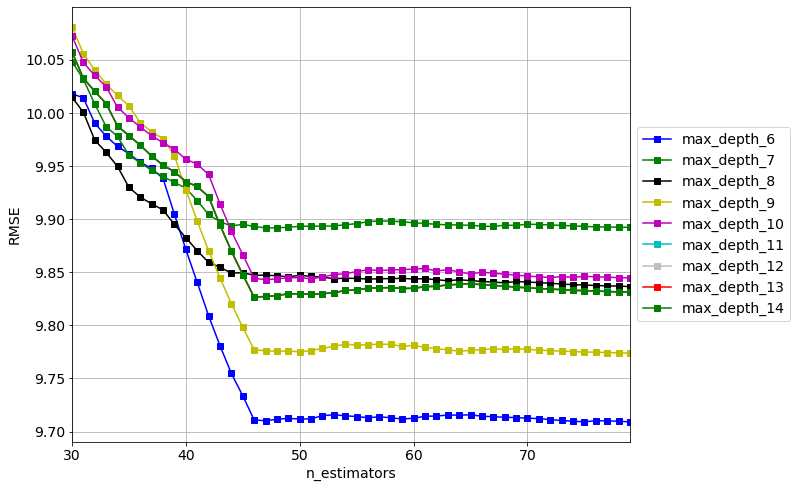

In [489]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [490]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 9.709
optimum params = 


(79, 6)

In [491]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 4.550%
optimum params = 


(47, 6)

In [493]:
param_label = 'learning_rate'
param_list = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]

param2_label = 'min_child_weight'
param2_list = range(10, 41, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['wheatPrice_mean3'],
                                     cv['wheatPrice_std3'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[16:12:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:12:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:12:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:12:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:12:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:12:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:12:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

,learning_rate,min_child_weight,rmse,mape_pct
0,0.005,10,13.260454,6.163753
1,0.005,11,13.355013,6.218906
2,0.005,12,13.167797,6.114452
3,0.005,13,13.198277,6.141704
4,0.005,14,13.147276,6.069359
5,0.005,15,13.073599,6.037922
6,0.005,16,13.075482,6.040764
7,0.005,17,13.077283,6.045446
8,0.005,18,13.086166,6.031840
9,0.005,19,13.313597,6.133702


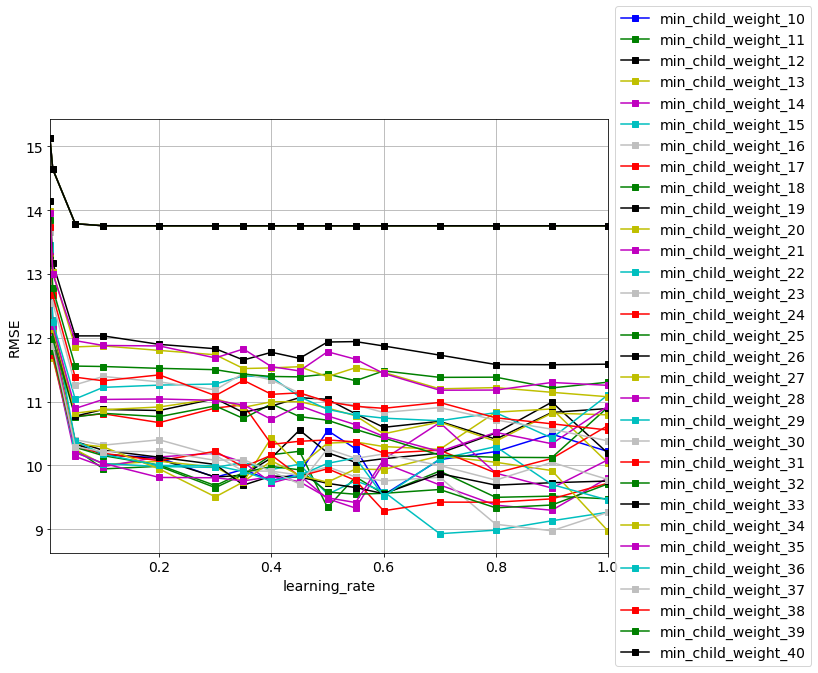

In [495]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [496]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 8.931
optimum params = 


(0.7, 15)

In [497]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 4.151%
optimum params = 


(0.8, 16)

In [501]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['wheatPrice_mean3'],
                                     cv['wheatPrice_std3'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[16:13:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:13:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

,subsample,gamma,rmse,mape_pct
0,0.1,0.1,14.515148,6.728683
1,0.1,0.2,14.515148,6.728683
2,0.1,0.3,14.515148,6.728683
3,0.1,0.4,14.515148,6.728683
4,0.1,0.5,14.515148,6.728683
5,0.1,0.6,14.515148,6.728683
6,0.1,0.7,14.515148,6.728683
7,0.1,0.8,14.515148,6.728683
8,0.1,0.9,14.515148,6.728683
9,0.1,1.0,14.515148,6.728683


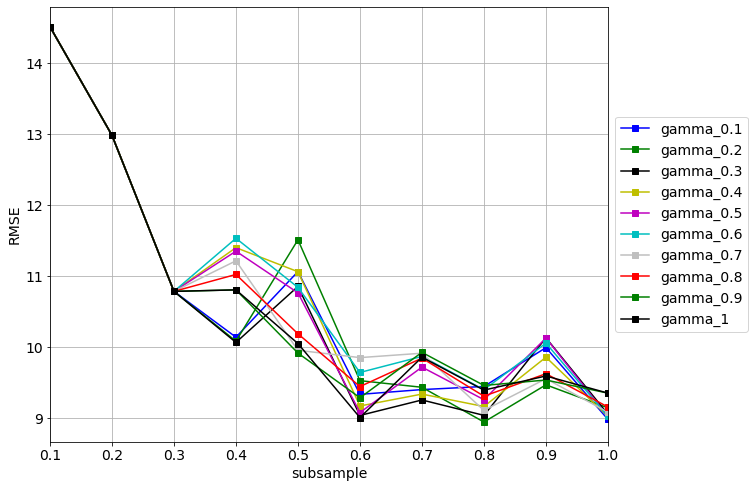

In [502]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [503]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 8.946
optimum params = 


(0.8, 0.2)

In [504]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 4.049%
optimum params = 


(1.0, 0.4)

In [506]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['wheatPrice_mean3'],
                                     cv['wheatPrice_std3'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[16:13:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,9.564944,4.640383
1,0.5,0.6,8.915438,4.360923
2,0.5,0.7,8.915438,4.360923
3,0.5,0.8,10.051722,4.995516
4,0.5,0.9,9.610791,4.643365
5,0.5,1.0,9.449625,4.445803
6,0.6,0.5,12.572383,5.572416
7,0.6,0.6,12.571760,5.904631
8,0.6,0.7,12.023957,5.609315
9,0.6,0.8,11.547350,5.263203


In [507]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,79.000
1,max_depth,3.000,6.000
2,learning_rate,0.100,0.700
3,min_child_weight,1.000,15.000
4,subsample,1.000,0.800
5,gamma,0.000,0.200
6,rmse,10.104,8.576
7,mape_pct,4.732,4.110


[16:14:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on dev set = 8.952
MAPE on dev set = 4.324%


Text(0, 0.5, 'USD')

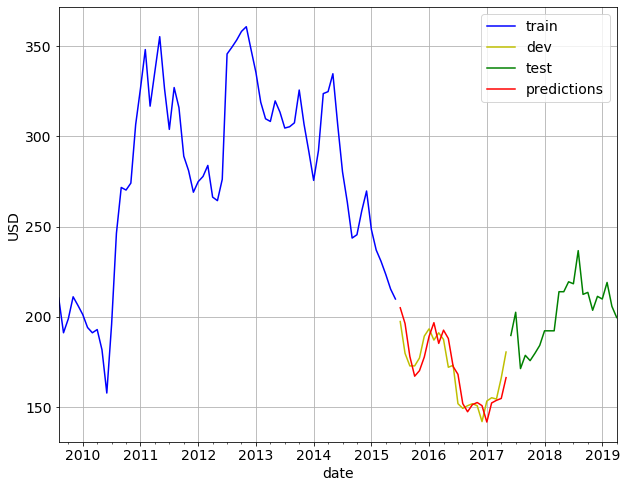

In [510]:
# Create the model
model = XGBRegressor(seed=model_seed,
                             n_estimators=n_estimators, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             gamma=gamma_opt)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['wheatPrice_std3'] + cv['wheatPrice_mean3']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='wheatPrice', style='b-', grid=True)
ax = cv.plot(x='date', y='wheatPrice', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='wheatPrice', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [568]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_test_new, 
                             y_test_new, 
                             test['wheatPrice_mean3'].head(15),
                             test['wheatPrice_std3'].head(15),          
                             seed=model_seed,
                             n_estimators=n_estimators, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

[16:40:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on test set = 12.411
MAPE on test set = 4.387%


Text(0, 0.5, 'USD')

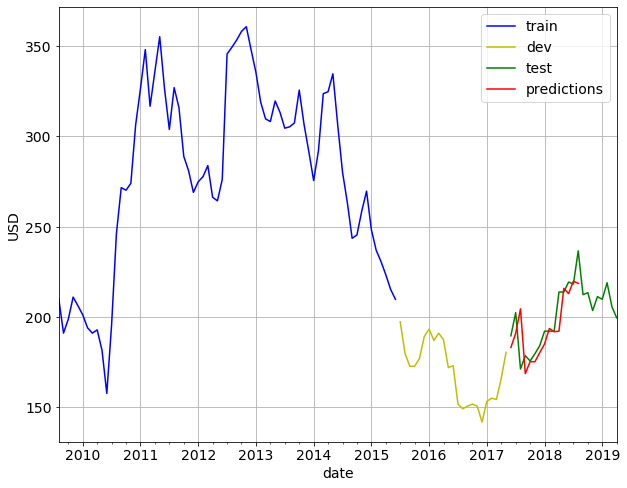

In [571]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
#                        'y_sample': y_sample,
                       'y_sample': y_test_new,
                       'date': test['date']})

ax = train.plot(x='date', y='wheatPrice', style='b-', grid=True)
ax = cv.plot(x='date', y='wheatPrice', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='wheatPrice', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

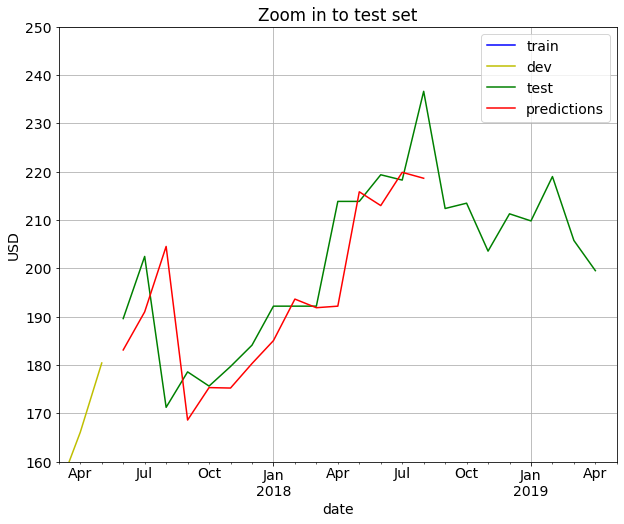

In [572]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='wheatPrice', style='b-', grid=True)
ax = cv.plot(x='date', y='wheatPrice', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='wheatPrice', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 3, 1), date(2019, 5, 1)])
ax.set_ylim([160, 250])
ax.set_title("Zoom in to test set")

In [573]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('goldPrice_std30', 0.021216935),
 ('goldPrice_mean15', 0.022126464),
 ('oilPrice_std3', 0.028083667),
 ('goldPrice_mean3', 0.029447999),
 ('goldPrice_std15', 0.0337557),
 ('goldPrice_std3', 0.033938095),
 ('oilPrice_mean3', 0.047086798),
 ('wheatPrice_lag_3', 0.047801126),
 ('goldPrice_mean30', 0.04969275),
 ('wheatPrice_lag_1', 0.6296937)]

(566, 592)

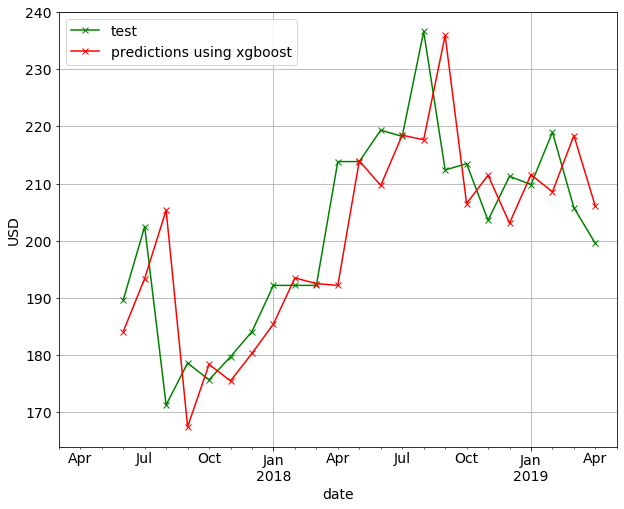

In [517]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='wheatPrice', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 3, 1), date(2019, 5, 1)])

In [518]:
rmse,mape

(12.265045003180429, 4.51212028693323)

In [519]:
from sklearn.linear_model import Lasso
lasso_opt = Lasso(alpha =55 ,max_iter = 1000)
lasso_opt.fit(X_train, y_train)
est = lasso_opt.predict(X_sample)
rmse = math.sqrt(mean_squared_error(y_sample, est))
mape = get_mape(y_sample, est)
rmse,mape

(14.557319978267374, 5.7578412541658865)

Text(0, 0.5, 'USD')

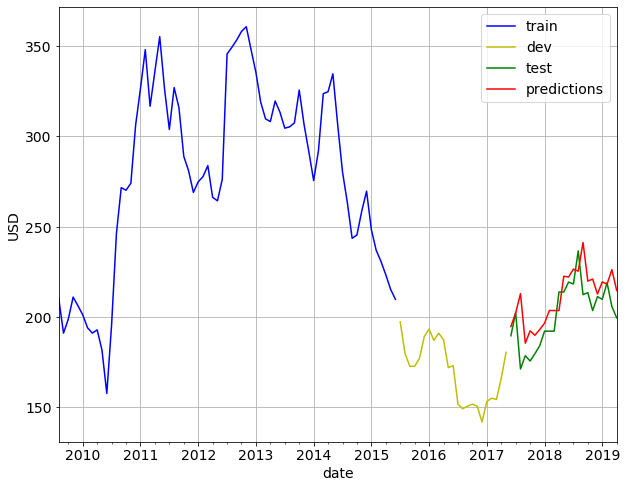

In [521]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='wheatPrice', style='b-', grid=True)
ax = cv.plot(x='date', y='wheatPrice', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='wheatPrice', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

(566, 592)

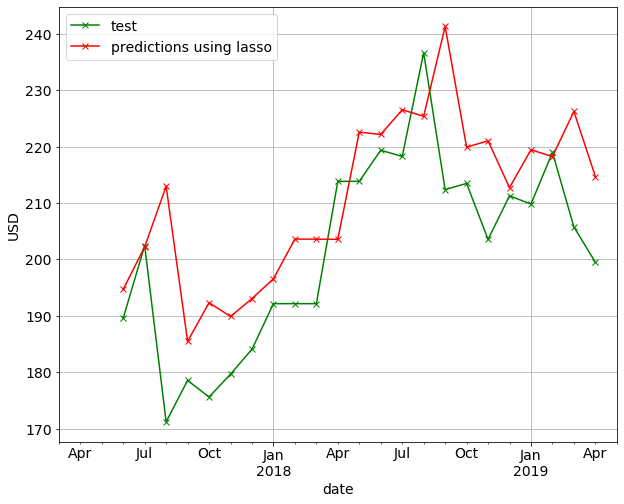

In [523]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='wheatPrice', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lasso'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 3, 1), date(2019, 5, 1)])

In [524]:
from sklearn.linear_model import Lasso
lasso_opt = Lasso(alpha =55 ,max_iter = 1000)
lasso_opt.fit(X_train, y_train)
est = lasso_opt.predict(X_cv)
rmse = math.sqrt(mean_squared_error(y_cv, est))
mape = get_mape(y_cv, est)
rmse,mape

(16.683468792833917, 8.91768932742136)

Text(0, 0.5, 'USD')

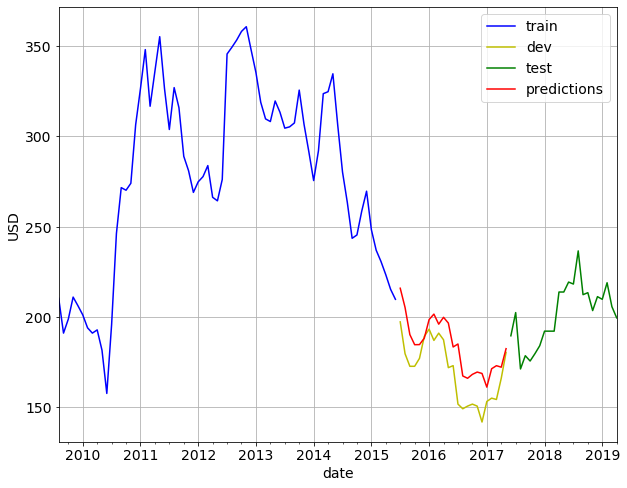

In [525]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='wheatPrice', style='b-', grid=True)
ax = cv.plot(x='date', y='wheatPrice', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='wheatPrice', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

(542, 570)

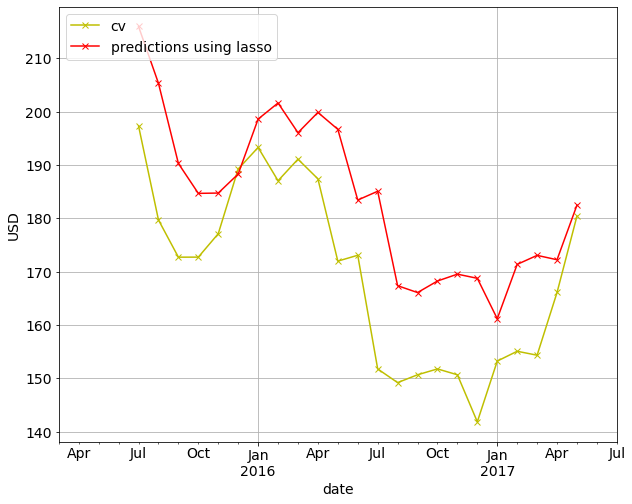

In [527]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = cv.plot(x='date', y='wheatPrice', style='yx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['cv', 'predictions using lasso'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2015, 3, 1), date(2017, 7, 1)])

In [528]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=0)
regr.fit(X_train, y_train)
est = regr.predict(X_sample)
rmse = math.sqrt(mean_squared_error(y_sample, est))
mape = get_mape(y_sample, est)
rmse,mape

(130.97055673134034, 64.47312656789332)

(566, 592)

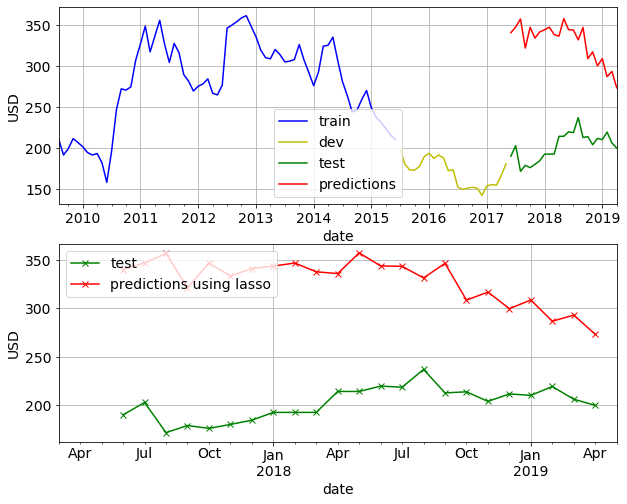

In [530]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
fig, (ax1, ax2) = plt.subplots(2,1)
est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax1 = train.plot(x='date', y='wheatPrice', style='b-', grid=True ,ax=ax1)
ax1 = cv.plot(x='date', y='wheatPrice', style='y-', grid=True, ax=ax1)
ax1 = test.plot(x='date', y='wheatPrice', style='g-', grid=True, ax=ax1)
ax1 = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax1)
ax1.legend(['train', 'dev', 'test', 'predictions'])
ax1.set_xlabel("date")
ax1.set_ylabel("USD")

rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax2 = test.plot(x='date', y='wheatPrice', style='gx-', grid=True, ax=ax2)
ax2 = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax2)
ax2.legend(['test', 'predictions using lasso'], loc='upper left')
ax2.set_xlabel("date")
ax2.set_ylabel("USD")
ax2.set_xlim([date(2017, 3, 1), date(2019, 5, 1)])



In [100]:
def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          alpha=1, \
                          max_iter=1000, \
                          l1_ratio=0.5):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = ElasticNet(alpha=alpha,l1_ratio=l1_ratio,max_iter=max_iter,random_state=0)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [101]:
param_label = 'alpha'
param_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

param2_label = 'l1_ratio'
param2_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]



error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Price_mean'],
                                     cv['Price_std'],
                                     alpha=param, 
                                     l1_ratio=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 0.005787964661916097


,alpha,l1_ratio,rmse,mape_pct
0,0.1,0.1,13.492325,6.056109
1,0.1,0.2,13.435860,6.018780
2,0.1,0.3,13.436730,6.016460
3,0.1,0.4,13.458842,6.027452
4,0.1,0.5,13.481400,6.038427
5,0.1,0.6,13.508324,6.047817
6,0.1,0.7,13.538964,6.058844
7,0.1,0.8,13.582507,6.073089
8,0.1,0.9,13.632730,6.089065
9,0.1,1.0,13.686952,6.103081


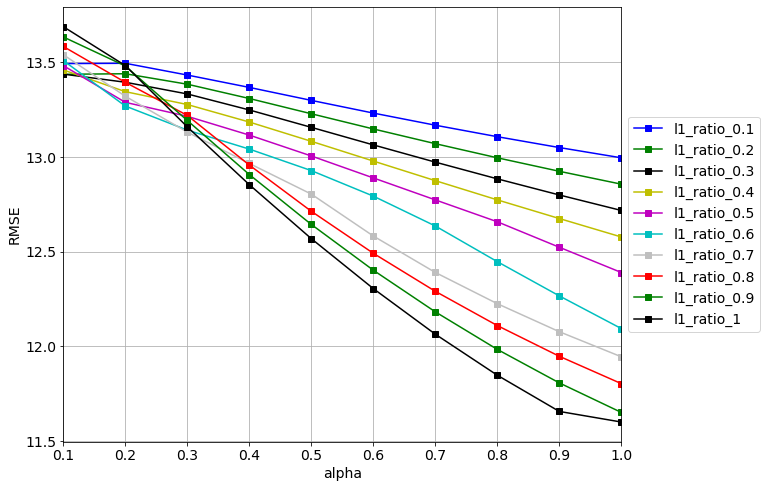

In [102]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [103]:
rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Price_mean'],
                                     cv['Price_std'],
                                     alpha=1, 
                                     max_iter=1000,
                                     l1_ratio=1)
rmse, mape

(11.60153728569208, 5.364916897527676)